# New Scaling

***

In [161]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.colors import Normalize
from matplotlib import cm
import os
import gsw
from datetime import datetime, timedelta
from dateutil.parser import parse
from tqdm import tqdm_notebook as tqdm
from warnings import simplefilter
from dynmodes import dynmodes
from salishsea_tools import viz_tools, geo_tools

%matplotlib inline
simplefilter('ignore')
plt.rcParams['font.size'] = 12

***

## Local Functions and Definitions

In [3]:
def build_GEM_mask(lon_HRDPS, lat_HRDPS, lon_NEMO, lat_NEMO, mask_NEMO):
    """
    """

    # Preallocate
    m, n = lon_HRDPS.shape
    mask_HRDPS = np.zeros(m*n, dtype=int)

    # Evaluate each point on GEM grid
    for index, lon, lat in zip(tqdm(range(m*n)), lon_HRDPS.flatten() - 360, lat_HRDPS.flatten()):

        j, i = geo_tools.find_closest_model_point(lon, lat, lon_NEMO, lat_NEMO)
        if j is np.nan or i is np.nan:
            mask_HRDPS[index] = 0
        else:
            mask_HRDPS[index] = mask_NEMO[j, i]

    # Reshape
    mask_HRDPS = mask_HRDPS.reshape(m, n)

    return mask_HRDPS

In [4]:
def calc_deformation_radius(rho, z_h, yx, e1t=440, angle=np.pi/2, tol=10):
    """Calculate the baroclinic Rossby deformation radius
    """

    scalefac = np.sin(angle) * e1t
    g_prime = const['g'] * (const['rho_0'] - rho) / const['rho_0']
    R = np.sqrt(g_prime * z_h * (const['H'] - z_h) / const['H']) / const['f']
    H, H_old = const['H'], 0
    while abs(H - H_old) > tol:
        H_old = H
        H = bathy.Bathymetry[yx]
        H = float(H[~np.isnan(H)][:int(R / scalefac)].mean())
        R = np.sqrt(g_prime * z_h * (H - z_h) / H) / const['f']

    return R

In [63]:
def calc_rho(data, depth, yx, tmask):
    """Calculate the density, rho
    """
    
    loc = (0,) + yx if type(depth) is int else (slice(None),) + yx
    rho = gsw.rho(*[np.ma.masked_where(tmask[loc] == 0, data[k][loc]) for k in tracers], depth)
    
    return rho

In [6]:
def make_prefix(date, paths, res='h'):
    """Construct path prefix for local SalishSeaCast results given date object and paths dict
    e.g., /results/SalishSea/hindcast.201812/ddmmmyy/SalishSea_1h_yyyymmdd_yyyymmdd
    """

    path = paths['NEMO']
    if 'date_cutoff' in paths and date >= parse(paths['date_cutoff']):
        path = paths['NEMO_cutoff']
    datestr = [date.strftime('%d%b%y').lower(), '_'.join(np.repeat(date.strftime('%Y%m%d'), 2))]
    prefix = os.path.join(path, datestr[0], f'SalishSea_1{res}_{datestr[1]}')
    
    return prefix

In [69]:
# Definitions
HRDPS = xr.open_dataset('https://salishsea.eos.ubc.ca/erddap/griddap/ubcSSaSurfaceAtmosphereFieldsV1')
grid_HRDPS = xr.open_dataset('https://salishsea.eos.ubc.ca/erddap/griddap/ubcSSaAtmosphereGridV1')
bathy = xr.open_dataset('/data/bmoorema/MEOPAR/grid/bathymetry_201702.nc')
mask = xr.open_dataset('/data/bmoorema/MEOPAR/grid/mesh_mask201702.nc')
const = {'g': 9.81, 'f': 1.11e-4, 'rho_0': 1024, 'H': 200, 'R': 5e3, 'z_h': 10}
depth2d = np.expand_dims(mask.gdept_1d[0, :], axis=1)
tracers = ['vosaline', 'votemper']
subdomain = [114, 398, 334, 898]
sections = [
    {'yx': (450, slice(235, 315)), 'yw': (137, 145), 'xw': (141, 149), 'a': np.arctan(10), 'c': 'r'},
    {'yx': (500, slice(205, 295)), 'yw': (145, 153), 'xw': (134, 141), 'a': np.arctan( 1), 'c': 'darkorange'},
    {'yx': (540, slice(175, 255)), 'yw': (151, 158), 'xw': (127, 133), 'a': np.arctan( 1), 'c': 'gold'},
    {'yx': (590, slice(130, 205)), 'yw': (159, 166), 'xw': (114, 121), 'a': np.arctan( 2), 'c': 'darkslategray'},
    {'yx': (640, slice(130, 180)), 'yw': (169, 174), 'xw': (109, 116), 'a': np.arctan(10), 'c': 'c'},
    {'yx': (680, slice(130, 200)), 'yw': (177, 181), 'xw': (108, 115), 'a': np.arctan( 5), 'c': 'cyan'},
]
for sec in sections:
    sec['e1t'] = float(mask.e1t[(0,) + sec['yx']].mean())
    for key in ['xw', 'yw']:
        sec[key] = np.round(np.linspace(*sec[key], 10)).astype(int)

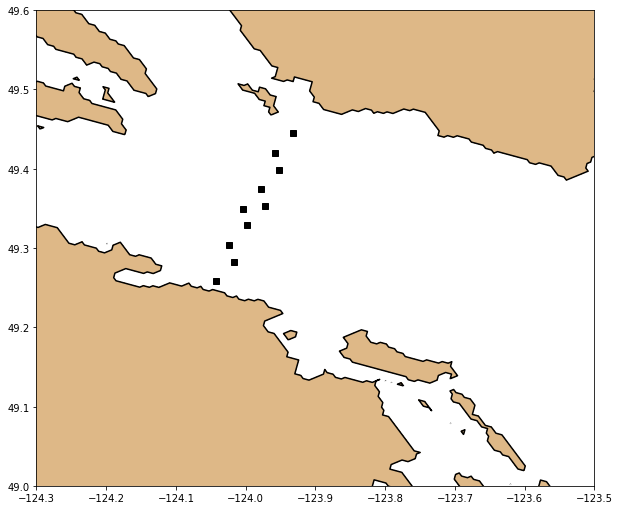

In [118]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.set_xlim([-124.3, -123.5])
ax.set_ylim([49, 49.6])
viz_tools.set_aspect(ax)
for attr, color in zip(['contourf', 'contour'], ['Burlywood', 'k']):
    getattr(ax, attr)(bathy.nav_lon, bathy.nav_lat, mask.tmask[0, 0, ...], levels=[-0.01, 0.01], colors=color)
    
xpoints = np.round(np.linspace(130, 135, 10)).astype(int)
ypoints = np.round(np.linspace(147, 155, 10)).astype(int)
for y, x in zip(ypoints, xpoints):
    ax.plot(grid_HRDPS.longitude[y, x]-360, grid_HRDPS.latitude[y, x], 'ks')

In [6]:
# Define path and filename string
path = '/data/bmoorema/results/Lake/S4d'
fn = 'SalishSeaIdeal_1h_20170701_20170706_grid_T.nc'
tmask = mask.tmask[0, :, slice(*subdomain[2:]), slice(*subdomain[:2])]

# Define scaling parameters
param = {
    'u_wind': [5, 10, 15],
    'tau': [0.034, 0.123, 0.280],
    'z_h': [10, 15, 20],
    'rho_surf': [1016, 1018, 1020],
}

# Initialize storage lists
R = [0, 0, 0, 0, 0, 0]

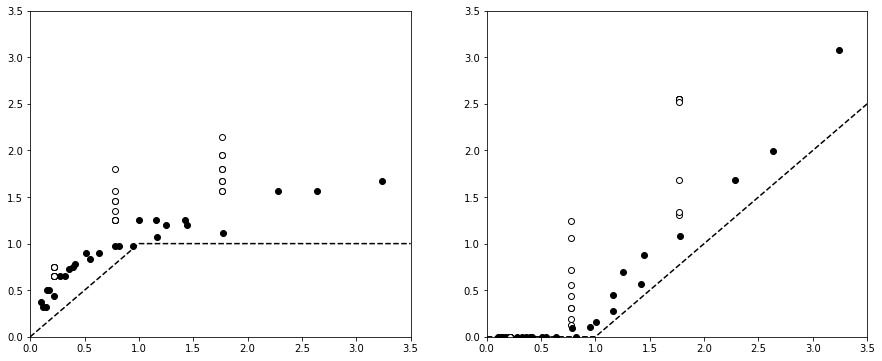

In [24]:
fig, axs = plt.subplots(1, 2, figsize=(15, 6))
for ax, x, y in zip(axs, [(0, 1, 3.5), (0, 1, 3.5)], [(0, 1, 1), (0, 0, 2.5)]):
    ax.plot(x, y, 'k--')
    ax.set_xlim([0, 3.5])
    ax.set_ylim([0, 3.5])
sec = sections[1]
hour = 24

# Loop though z_h and rho_surf
for z_h in tqdm(param['z_h']):
    for rho_s in param['rho_surf']:

        # Calculate deformation radius
        R = calc_deformation_radius(rho_s, z_h, (sec['x'][0], sec['y']), angle=sec['a'])

        # Loop through wind speed
        for U, tau in zip(param['u_wind'], param['tau']):

            # Open results record
            runID = f'SalishSeaPond_S4d{U:02d}ms_halocline{z_h:2d}m_rhosurf{rho_s:4d}'
            with xr.open_dataset(os.path.join(path, runID, fn)) as data:
                
                for zh, r, color in zip([z_h, 10], [R, 1e4], ['k', 'w']):

                    # Loop through sections
                    scale = np.cos(np.arctan(2) - sec['a']) * tau * 3600 / (const['rho_0'] * zh * const['f'] * r)
                    xy = (sec['y'] - subdomain[2], slice(*[x - subdomain[0] for x in sec['x']]))
                    rho_t0 = calc_rho(data, depth2d, (0,slice(None))+xy, tmask, time=True)
                    rho_halo = np.median(rho_t0[abs(depth2d[:, 0] - zh).argmin(), :])

                    # Loop through hours
                    scale_T = (hour - 3) * scale
                    rho = calc_rho(data, 0, (hour,0)+xy, tmask, time=True)
                    z_u = depth2d[int(np.median(abs(rho_t0 - rho.max()).argmin(axis=0))), 0] / zh
                    x_u = np.sin(sec['a']) * (rho >= rho_halo).sum() * 440 / r
                    axs[0].plot(scale_T, z_u, 'ko', markerfacecolor=color)
                    axs[1].plot(scale_T, x_u, 'ko', markerfacecolor=color)

***

## Hindcast scaling results

In [8]:
# Define paths and variables
paths = {
    'NEMO': '/results/SalishSea/hindcast.201812',
    'NEMO_cutoff': '/results2/SalishSea/hindcast.201812_annex',
    'date_cutoff': '2016 Nov 21',
}
tmask = mask.tmask[0, ...]
depthw = (depth2d[1:, 0] + depth2d[:-1, 0]) / 2

In [169]:
# Upwelling event date windows
dates = [
    '2015 Mar 11 04:00',
    '2015 Mar 18 17:00',
    '2015 Mar 24 22:00',
    '2015 Mar 28 18:00',
    '2015 Apr 02 17:00',
    '2015 Apr 09 20:00',
    '2015 Apr 12 18:00',
    '2015 Apr 25 23:00',
    '2015 Aug 28 00:00',
    '2015 Sep 18 00:00',
    '2015 Sep 22 16:00',
    '2016 Mar 23 10:00',
    '2016 Apr 11 13:00',
    '2016 Jun 01 18:00',
    '2016 Jul 07 14:00',
    '2016 Aug 28 12:00',
    '2016 Sep 16 12:00',
    '2016 Sep 22 20:00',
    '2017 Mar 01 20:00',
    '2017 Mar 06 23:00',
    '2017 Mar 11 07:00',
    '2017 Mar 16 12:00',
    '2017 Mar 21 15:00',
    '2017 Mar 26 08:00',
    '2017 Apr 03 23:00',
    '2017 Apr 07 19:00',
    '2017 Apr 13 12:00',
    '2017 Apr 17 18:00',
    '2017 May 15 12:00',
    '2017 May 30 04:00',
    '2017 Jun 14 17:00',
    '2017 Sep 08 23:00',
    '2017 Sep 17 02:00',
    '2017 Oct 21 05:00',
    '2018 Mar 14 00:00',
    '2018 Mar 22 07:00',
    '2018 Mar 25 19:00',
    '2018 Apr 04 08:00',
    '2018 Apr 07 07:00',
    '2018 Apr 12 23:00',
    '2018 Apr 20 12:00',
    '2018 Jun 01 12:00',
    '2018 Jun 05 12:00',
    '2018 Sep 07 13:00',
    '2018 Sep 14 13:00',
    '2018 Sep 20 17:00',
    '2018 Oct 23 06:00',
]

In [176]:
hour = 24
events = []
rho_t0 = [0, 0, 0, 0, 0, 0]

# Loop though events and hours
for Date in tqdm(dates):
    event = {}
    event['date'] = parse(Date)
    event['sections'] = [{}, {}, {}, {}, {}, {}]
    
    for hour in [0, hour]:

        date = event['date'] + timedelta(hours=hour)

        # Open hindcast record
        with xr.open_dataset(make_prefix(date, paths) + '_grid_T.nc') as data:

            # Loop through sections
            for n, sec, esec in zip(range(6), sections, event['sections']):

                # Calculations at t=0
                if hour == 0:
                    
                    # Calculate stratification parameters
                    rho_t0[n] = calc_rho(data.sel(time_counter=date, method='nearest'), depth2d, sec['yx'], tmask)
                    N2 = const['g'] / const['rho_0'] * np.diff(rho_t0[n], axis=0) / np.diff(depth2d, axis=0)
                    modes = dynmodes(np.ma.median(N2[:, :20], axis=1).compressed()[:24], depthw[:24], 1)
                    z_h = depthw[int(np.where(np.diff(np.signbit(modes[1][0, :])))[0])]
                    rho_surf = rho_t0[n][:int(z_h), :].mean()
                    rho_halo = np.median(rho_t0[n][abs(depth2d[:, 0] - z_h).argmin(axis=0), :])
                    R = calc_deformation_radius(rho_surf, z_h, sec['yx'], angle=sec['a'])
                    esec.update({'rho_halo': rho_halo, 'rho_surf': rho_surf, 'R': R, 'z_h': z_h})

                # Calculations at hours
                else:

                    # Calculate tau
                    u, v = [HRDPS.sel(time=slice(event['date'], date))[k].values[:, sec['yw'], sec['xw']] for k in ['u_wind', 'v_wind']]
                    coeff = np.cos(np.pi * (22 / 180 + 1) - np.arctan2(v, u) - sec['a'])
                    tau = sum(1.225e-3 * (coeff * (u**2 + v**2)).mean(axis=1)) * 3600
                    
                    # Calculate upwelling metrics
                    rho = calc_rho(data.sel(time_counter=date, method='nearest'), 0, sec['yx'], tmask)
                    rho_max = rho[:max(1, int(esec['R'] / sec['e1t']))].max()
                    z_u = depth2d[int(np.median(abs(rho_t0[n] - rho_max).argmin(axis=0))), 0]
                    x_u = np.sin(sec['a']) * (rho >= esec['rho_halo']).sum() * sec['e1t']
                    esec.update({'tau': tau, 'z_u': z_u, 'x_u': x_u})
    events.append(event)

### Scaling plots

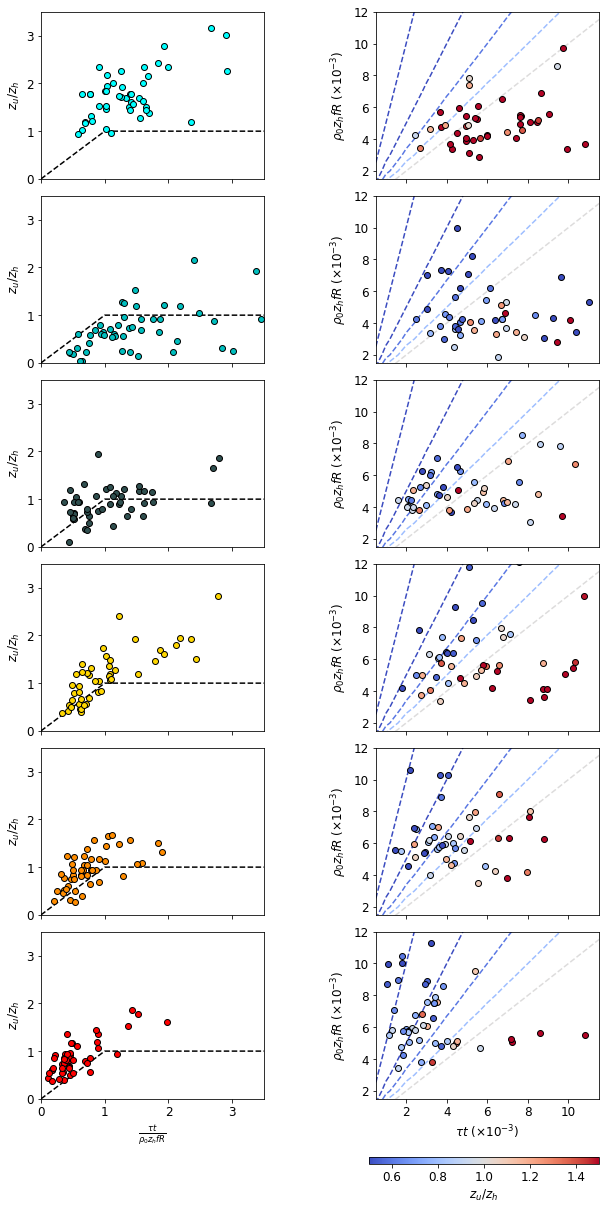

In [250]:
x, y = np.meshgrid(np.arange(0, 15), np.arange(0, 15))
norm = Normalize(vmin=0.5, vmax=1.5)
m = cm.ScalarMappable(norm=norm, cmap=cm.coolwarm)
levels=[0.2, 0.4, 0.6, 0.8, 1]

xlims, ylims = [(0, 3.5), (0.5, 11.5)], [(0, 3.5), (1.5, 12)]
xlabels, ylabels = ['$\\frac{\\tau t}{\\rho_0 z_h f R}$', '$\\tau t$ ($\\times 10^{-3}$)'], ['$z_u / z_h$', '$\\rho_0 z_h f R$ ($\\times 10^{-3}$)']

fig, axs = plt.subplots(6, 2, figsize=(10, 20), gridspec_kw={'hspace': 0.1, 'wspace': 0.5})
cax = fig.add_axes([0.58, 0.08, 0.32, 0.005])
for n, row in enumerate(axs):
    for ax, xlim, ylim, xlabel, ylabel in zip(row, xlims, ylims, xlabels, ylabels):
        ax.plot((0, 1, 3.5), (0, 1, 1), 'k--')
        ax.set_xlim(xlim)
        ax.set_ylim(ylim)
        ax.set_ylabel(ylabel)
        if n == 5: ax.set_xlabel(xlabel)
        else: ax.xaxis.set_ticklabels('')
    row[1].contour(x, y, x/y, levels=levels, colors=m.to_rgba(levels), linestyles='dashed')

for event in events:
    for row, sec, section in zip(axs[::-1, :], sections, event['sections']):
        scaling = const['rho_0'] * section['z_h'] * const['f'] * section['R']
        scaling2 = const['rho_0'] * const['z_h'] * const['f'] * const['R']
        row[0].plot(section['tau'] / scaling, section['z_u'] / section['z_h'], 'ko', markerfacecolor=sec['c'])
        row[1].plot(section['tau'] * 1e-3, scaling * 1e-3, 'ko', markerfacecolor=m.to_rgba(section['z_u'] / section['z_h']))
        
m.set_array([])
fig.colorbar(m, cax=cax, orientation='horizontal', label='$z_u / z_h$')

### Wind timeseries

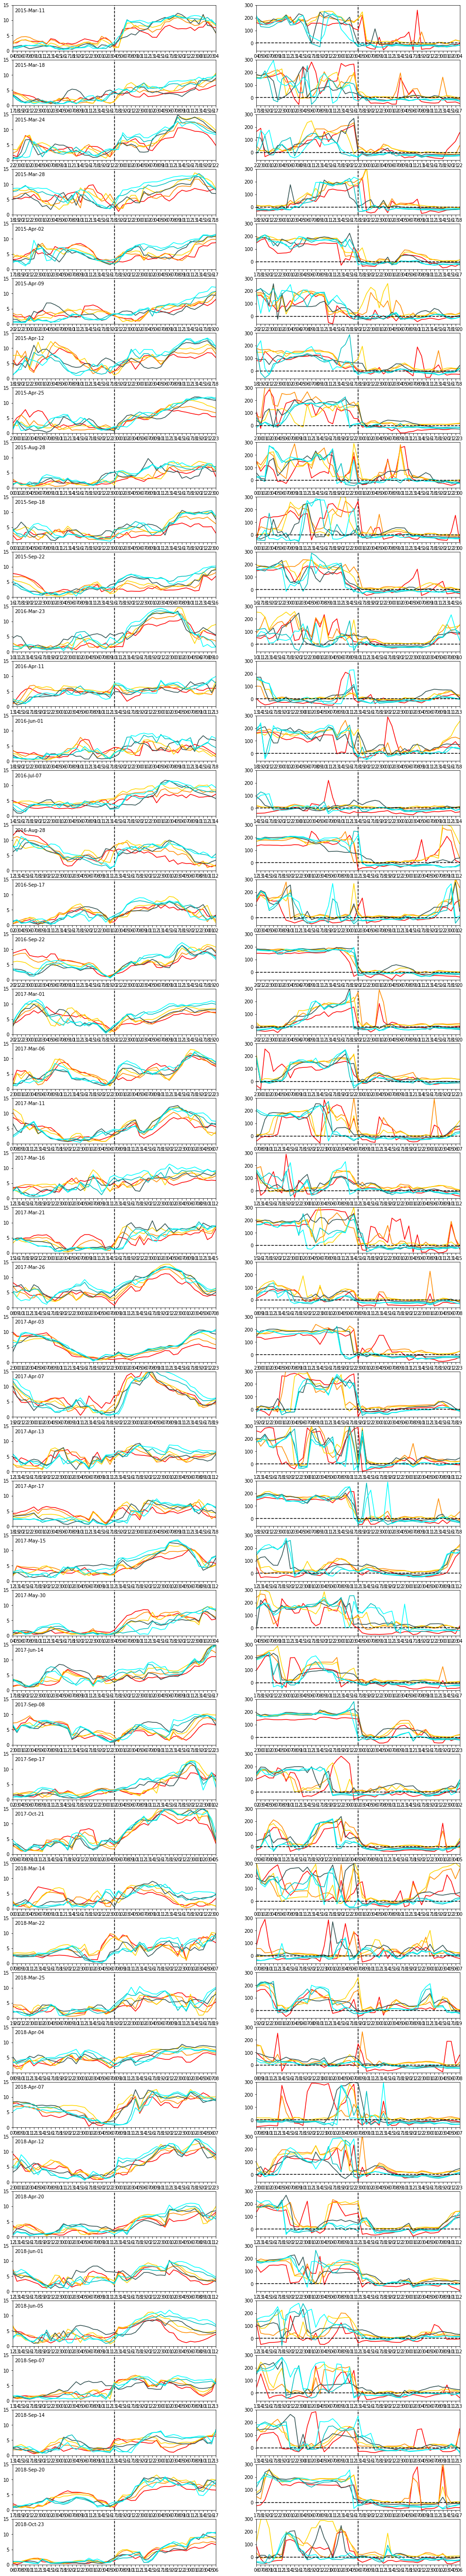

In [192]:
# Make figure layout
fig, axs = plt.subplots(47, 2, figsize=(17, 100))

# Loop though events and hours
for row, event in zip(tqdm(axs), events):
    date = (event - timedelta(hours=24), event + timedelta(hours=24))
    time = HRDPS.sel(time=slice(*date)).time
    for ax, ylim in zip(row, [(0, 15), (-60, 300)]):
        ax.set_xlim(date)
        ax.set_ylim(ylim)
        ax.xaxis.set_major_locator(mdates.HourLocator())
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%H'))
        ax.plot([event, event], ylim, 'k--')
    for sec in sections:
        u, v = [HRDPS.sel(time=slice(*date))[k].values[:, sec['yw'], sec['xw']] for k in ['u_wind', 'v_wind']]
        mag = np.sqrt(u**2 + v**2).mean(axis=1)
        angle = 180 * (1 - (np.arctan2(v, u).mean(axis=1) + sec['a']) / np.pi) + 22
        row[0].plot(time, mag, '-', color=sec['c'])
        row[1].plot(time, angle, '-', color=sec['c'])
    row[0].text(0.01, 0.85, event.strftime('%Y-%b-%d'), transform=row[0].transAxes)
    row[1].plot(date, [0, 0], 'k--')